In [17]:
import torch
import pyro
import matplotlib.pyplot as plt
pyro.set_rng_seed(1)

### Pyro Stochastic Function

$cloudy \sim Ber(0.3) $<br>
$temp|cloudy=1 \sim N(55.0, 10)$<br>
$temp|cloudy=0 \sim N(75.0, 15)$<br>

In [2]:
def weather():
    cloudy = pyro.sample('cloudy', pyro.distributions.Bernoulli(0.3))
    mu, sigma = (55., 10.) if cloudy.item() == 1. else (75., 15.)
    temp = pyro.sample('temp', pyro.distributions.Normal(mu, sigma))
    return cloudy, temp

In [3]:
for _ in range(3):
    print(weather())

(tensor(0.), tensor(77.9911))
(tensor(0.), tensor(105.5909))
(tensor(0.), tensor(92.4914))


### Stochastic Recursion

$geometric(p) = $ how many random variables until a 1 is sampled<br>
$X_i \sim Ber(p)$<br>

In [4]:
def geometric(p, t=0):
    xt = pyro.sample("x%d" % t, pyro.distributions.Bernoulli(p))
    if xt.item() == 0:
        return 1+geometric(p, t=t+1)
    else:
        return 0

In [5]:
geometric(0.5)

2

### Pyro Inference

Consider the following model of measurement given a guess:

$weight|guess \sim N(guess, 1)$<br>
$measure|guess, weight \sim N(weight, 0.75)$

In [6]:
def scale(guess):
    weight = pyro.sample("weight", pyro.distributions.Normal(guess, 1))
    measure = pyro.sample("measure", pyro.distributions.Normal(weight, 0.75))
    return measure

Given guess = 8.5, measure = 9.5, what is the distribution:

$weight|guess=8.5,measure=9.5$

We can first condition `scale` on $measure=9.5$.

In [7]:
conditioned_scale = pyro.condition(scale, data={'measure': 9.5})

Then we can create a distribution $q(weight)$ to do variational inference.

In [13]:
def scale2(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=torch.distributions.constraints.positive)
    weight = pyro.sample("weight", pyro.distributions.Normal(a, b))
    return weight

Now we can do SVI.

In [14]:
svi = pyro.infer.SVI(
    model = conditioned_scale,
    guide = scale2,
    optim = pyro.optim.SGD({'lr': 0.001}),
    loss = pyro.infer.Trace_ELBO(),
)

In [15]:
losses, a, b = [], [], []

In [16]:
guess = 8.5
for i in range(2500):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

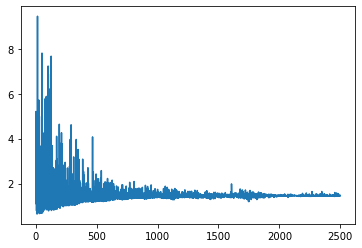

In [18]:
plt.plot(range(2500), losses)

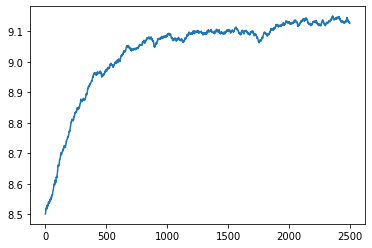

In [19]:
plt.plot(range(2500), a)

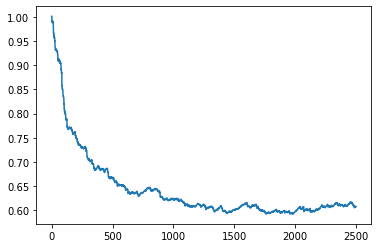

In [20]:
plt.plot(range(2500), b)